# <center>StableOneV2 Smart Contract Analysis</center>


Stable One V2 is a __daily ROI project__, a smart contract that is deployed on polygon network. The project promises 7% daily ROI with a minimum requirement of 0.05 MATIC. The initial investment is locked away and will never be returned. The investor has the right but not the obligation to withdraw or reinvest once in a rolling 24 hour period. When an investor withdraw, s/he only withdraw 75% of the interest owed. When an investor reinvest the interest, 21% of the interest is added to the original principal. The maximum payout is claimed to be 210% which is twice the money you put in. Although the project is marketed as ROI project and touting investment/re-investment, there is nothing the project really invest in. When people invest in the contract, the contract balance grows. When the contract balance goes to zero, the contract ends and there is nothing left for investor to withdraw. The contract was created on 2/20/2022 and ended  on 3/11/2022. [Stable One](https://stableone.io/) is running a V3 daily ROI contract with 8% daily interest as of 3/14/2022.

The purpose of this notebook is to preform __on-chain analysis__ to study the statistical characteristics of such daily ROI project and to understand:
* Profit and loss distribution among contract participants
* Investor behaviors

By analyzing transaction data on StableOneV2 smart contract [0xe306726C970210541954f25191cB188b6771d9E0](https://polygonscan.com/address/0xe306726c970210541954f25191cb188b6771d9e0/), we can reconstruct how many investments are made by each wallet and on which day. By looking internal transactions from the contract, we can figure out how many withdrawal and referral bonus are made and on which day. From these, we can gain insight how this daily ROI project works, whether one should invest, and if there is a strategy for an investor to be profitable. 

At a very high level, this kind of daily ROI project is more like a ponzi where early investors get paid by later investors. Majority of the investors lose money. And of course, "the house", or the contract operator ("primary beneficiary" of this contract), always wins. Out of all the investments (about 1.9M MATICs) that investor put into the smart contract, the primary beneficiary received about 21% payout and investors were only able to recover about 79%. __And out of 5568 investors (more precisely wallets), about 77% investors lost money.__

<table><tr>
<td> <img src="images/stableone_payout.png"/> </td>
<td> <img src="images/stableone_return.png"/> </td>
</tr></table>

As further analysis shows, to be profitable an investor should invest early, probably the first day of contract launch, reinvest daily, withdraw before the contract balance runs out. For optimal withdraw timing, write a program to monitor contract balance and project withdrawal in the next 24 hours when making reinvest and withdraw decisions. The other trick to ensure higher chance of profitability is to set up 5 levels of referral chain to capture 10.5% of the original investment. How could anyone know this? By studying the contract [solidity code](https://polygonscan.com/address/0xe306726c970210541954f25191cb188b6771d9e0#code).

The lesson for this analysis? __Do thorough research and really, I mean really, understand the contract before you invest in DeFi__ &#128512;


In [1]:
import pandas as pd
import asyncio
import aiohttp
from datetime import datetime
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline

#### Helper Functions

Provide a valid polyganscan API key below to run the notebook. You can obtain a free API key from https://polygonscan.com/apis

In [2]:
POLYGON_API_KEY="YOUR API KEY GOES HERE..."
POLYGON_PREFIX="https://api.polygonscan.com/"

In [3]:
# increase the data rate limit to run the program if needed
# jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10

async def get_all_normal_transactions(prefix, apikey, address, startblock=0):
    """
    apikey: API key
    address: the address to sell all transactions
    startblock: it is not recommended to using 0. BSC has no problem. Polygon sometimes would complain the range is too large. 
                So start with a block number just before contract creation.
                
    return: list of transactions. 
    """
    count = 10000

    output = []
    # API only return 10000 results at a time. So we have to loop
    while count > 9999:
        async with aiohttp.ClientSession() as session:
            url = f"{prefix}api?module=account&action=txlist&address={address}&startblock={startblock}&endblock=99999999&sort=asc&apikey={apikey}"
            #print(url)
            async with session.get(url) as resp:
                ret = await resp.json()
        
        if ret['status'] == '1':
            output.extend(ret['result'])      
            count = len(ret['result'])
            startblock = ret['result'][count - 1]['blockNumber']
        else:
            print("error.", ret)
            count = 0
    
    return output


# TODO: refactor the code as the main difference between the two functions are url...
async def get_all_internal_transactions(prefix, apikey, address, startblock=0):
    """
    apikey: API key
    address: the address to sell all transactions
    startblock: it is not recommended to using 0. BSC has no problem. Polygon sometimes would complain the range is too large. 
                So start with a block number just before contract creation.
                
    return: list of transactions. 
    """
    count = 10000

    output = []
    # API only return 10000 results at a time. So we have to loop
    while count > 9999:
        async with aiohttp.ClientSession() as session:
            url = f"{prefix}api?module=account&action=txlistinternal&address={address}&startblock={startblock}&endblock=99999999&sort=asc&apikey={apikey}"
            #print(url)
            async with session.get(url) as resp:
                ret = await resp.json()
        
        if ret['status'] == '1':
            output.extend(ret['result'])      
            count = len(ret['result'])
            startblock = ret['result'][count - 1]['blockNumber']
        else:
            print("error.", ret)
            count = 0
    
    return output

#### Get all transactions for 0xe306726C970210541954f25191cB188b6771d9E0 - StableOneV2, a daily ROI contract 

In [4]:
CONTRACT_ADDRESS = '0xe306726C970210541954f25191cB188b6771d9E0'
START_BLOCK = 25190592

output = await get_all_normal_transactions(prefix=POLYGON_PREFIX, 
                                           apikey=POLYGON_API_KEY, 
                                           address=CONTRACT_ADDRESS, 
                                           startblock=START_BLOCK)

# put data in dataframe for analysis
all_tx = pd.DataFrame.from_dict(output)
#all_tx = all_tx.drop_duplicates(subset = ['hash'], keep = 'last').reset_index(drop = True)
all_tx = all_tx[all_tx['isError'] == '0']
all_tx.tail(10)

,blockNumber,timeStamp,hash,nonce,blockHash,transactionIndex,from,to,value,gas,gasPrice,isError,txreceipt_status,input,contractAddress,cumulativeGasUsed,gasUsed,confirmations
58114,25934532,1647264456,0x104d566c1724de3d503432ee340d6aa726cd8f5dddd3...,6,0x435736b14fb74a5d39e407665e7705269ceed4e1cbf3...,30,0x98da174121f415f8afd4c60daa332c66f3b17c9d,0xe306726c970210541954f25191cb188b6771d9e0,0,164578,30062149420,0,1,0x3ccfd60b,,29499378,88909,313391
58115,25934534,1647264460,0x55ab26ec0376cb9a48a0f7657e7dd3fdf282179a26a7...,378,0xf2062a1584db75a14c7da7f7970da373744394d4a683...,34,0xae724da846a3a3654af3d932898d8d6197724293,0xe306726c970210541954f25191cb188b6771d9e0,0,164578,31893891385,0,1,0x3ccfd60b,,4803076,88909,313389
58116,25934536,1647264464,0x09db41514c88cac09b9e2a7cf00929ee5b539d1ec589...,30,0x068cf84df9a44905cdce637e45a656021e40ce2bb11d...,236,0x8e11a4356118587ad57394a07a89d16ff93fe65c,0xe306726c970210541954f25191cb188b6771d9e0,0,164589,30062149422,0,1,0x3ccfd60b,,26143827,88916,313387
58118,25934633,1647264665,0x6703b6131a66792e9ae6990df35c6b65313ae233441d...,8,0x2be19f662a9cf50c085ac27e48f81c0f040a2e1d26d7...,48,0x045167745c67800578da505c3cfe5c309befb9c3,0xe306726c970210541954f25191cb188b6771d9e0,200000000000000000000,254782,30061823097,0,1,0x03f9c79300000000000000000000000037a963146a33...,,6420251,168989,313290
58119,25934649,1647264697,0xade5128d1c837f8d01bb6dad36583130954cd3fb07d9...,53,0x66bce8a5bd4a22ab7bd39f29644ea49cc495a12b55d9...,46,0xb4f95aff3e3d7efa09a5b3188eb043ab1e6c0fa3,0xe306726c970210541954f25191cb188b6771d9e0,0,164578,30379999995,0,1,0x3ccfd60b,,8363312,88909,313274
58120,25934658,1647264719,0x19df23e799bd78073f96e79f9e5761af823a9fea626b...,41,0x66b9f2f22fdcb97231e1311ae0874c00c07688a29258...,32,0x5c5e982b047ade850352952cfc4c495c2b7f5b25,0xe306726c970210541954f25191cb188b6771d9e0,0,164589,30061823100,0,1,0x3ccfd60b,,5331579,88916,313265
58163,26006543,1647440314,0xd61b7f1787cc1c11f7e210d9d95322757af23306991c...,9,0x7a2b286335534e5a4f41a1207470aae637dfd74c1bc7...,121,0xf67f1c661d570a3f803b8e6d9431c72931226c62,0xe306726c970210541954f25191cb188b6771d9e0,7800000000000000000,147705,30070000000,0,1,0x03f9c79300000000000000000000000037a963146a33...,,23119891,114704,241380
58164,26006543,1647440314,0xc1b7a8659e8d713543dab9e1607218169f7178fd11ac...,10,0x7a2b286335534e5a4f41a1207470aae637dfd74c1bc7...,122,0xf67f1c661d570a3f803b8e6d9431c72931226c62,0xe306726c970210541954f25191cb188b6771d9e0,7800000000000000000,147705,34316660002,0,1,0x03f9c79300000000000000000000000037a963146a33...,,23204511,84620,241380
58167,26006550,1647440328,0x34477e19de27afca8496f86f46d130aa064d21dfad4e...,13,0x2323ae62219c39cd7bed2182d9a7cd0260051da9ebc9...,63,0xf67f1c661d570a3f803b8e6d9431c72931226c62,0xe306726c970210541954f25191cb188b6771d9e0,0,135574,30063556876,0,1,0xfdb5a03e,,10022011,73283,241373
58175,26006579,1647440386,0xe402744e933c4c43a735c079a45d44c95be186e3a95d...,396,0x8f0c5b3eb15ffe11db1e984da2d392a3e91a22283daf...,52,0xae724da846a3a3654af3d932898d8d6197724293,0xe306726c970210541954f25191cb188b6771d9e0,0,164589,39912727228,0,1,0x3ccfd60b,,6140853,88916,241344


#### Let's group transactions together
We are most interested in "Withdraw" and "Invest" calls. The method id are 0x3ccfd60b and 0x03f9c793

In [5]:
all_invest = all_tx[all_tx.input.str.startswith('0x03f9c793')]
all_withdraw = all_tx[all_tx.input == '0x3ccfd60b']

In [6]:
# convert to human readable format
DECIMAL = 1e18
all_invest['Investment'] = all_invest.value.astype(float)/DECIMAL
all_invest['UTC_Date'] = pd.to_datetime(all_invest.timeStamp, unit='s')

df2 = all_invest.groupby(all_invest['UTC_Date'].dt.date).sum()
print("Total MATIC deposited: ", df2.Investment.sum())

Total MATIC deposited:  1909919.6340416349


C:\Users\davefang\.conda\envs\textmining\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\davefang\.conda\envs\textmining\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


#### Let's figure out how much money investors withdraw as the external transaction does not give a clue
The withdraw function transaction does not give out information about the withdraw amount. But each call generate two internal transactions. We can pull all internal transactions.

In [7]:
output2 = await get_all_internal_transactions(prefix=POLYGON_PREFIX, 
                                             apikey=POLYGON_API_KEY, 
                                             address=CONTRACT_ADDRESS, 
                                             startblock=START_BLOCK)

In [8]:
all_internal_tx = pd.DataFrame.from_dict(output2)
#all_internal_tx.to_excel('internal_tx.xlsx')
all_internal_tx = all_internal_tx[all_internal_tx['isError'] == '0']
all_internal_tx['UTC_Date'] = pd.to_datetime(all_internal_tx.timeStamp, unit='s')
all_internal_tx.tail(10)

,blockNumber,timeStamp,hash,from,to,value,contractAddress,input,type,gas,gasUsed,traceId,isError,errCode,UTC_Date
92361,25934649,1647264697,0xade5128d1c837f8d01bb6dad36583130954cd3fb07d9...,0xe306726c970210541954f25191cb188b6771d9e0,0xb4f95aff3e3d7efa09a5b3188eb043ab1e6c0fa3,2904061452523274714,,,call,2300,0,0_1,0,,2022-03-14 13:31:37
92362,25934658,1647264719,0x19df23e799bd78073f96e79f9e5761af823a9fea626b...,0xe306726c970210541954f25191cb188b6771d9e0,0x37a963146a33ae93dc314461534ef12dccd2fb32,45211856428882783958,,,call,2300,0,0_1,0,,2022-03-14 13:31:59
92363,25934658,1647264719,0x19df23e799bd78073f96e79f9e5761af823a9fea626b...,0xe306726c970210541954f25191cb188b6771d9e0,0x5c5e982b047ade850352952cfc4c495c2b7f5b25,110777212657141084819,,,call,2300,0,0_1,0,,2022-03-14 13:31:59
92364,26006543,1647440314,0xd61b7f1787cc1c11f7e210d9d95322757af23306991c...,0xe306726c970210541954f25191cb188b6771d9e0,0xef9cfa8ee8bf3d3ce83f9685f0217a0c6e377dd2,390000000000000000,,,call,2300,0,0_1,0,,2022-03-16 14:18:34
92365,26006543,1647440314,0xd61b7f1787cc1c11f7e210d9d95322757af23306991c...,0xe306726c970210541954f25191cb188b6771d9e0,0x37a963146a33ae93dc314461534ef12dccd2fb32,780000000000000000,,,call,2300,0,0_1,0,,2022-03-16 14:18:34
92366,26006543,1647440314,0xc1b7a8659e8d713543dab9e1607218169f7178fd11ac...,0xe306726c970210541954f25191cb188b6771d9e0,0xef9cfa8ee8bf3d3ce83f9685f0217a0c6e377dd2,390000000000000000,,,call,2300,0,0_1,0,,2022-03-16 14:18:34
92367,26006543,1647440314,0xc1b7a8659e8d713543dab9e1607218169f7178fd11ac...,0xe306726c970210541954f25191cb188b6771d9e0,0x37a963146a33ae93dc314461534ef12dccd2fb32,780000000000000000,,,call,2300,0,0_1,0,,2022-03-16 14:18:34
92368,26006550,1647440328,0x34477e19de27afca8496f86f46d130aa064d21dfad4e...,0xe306726c970210541954f25191cb188b6771d9e0,0x37a963146a33ae93dc314461534ef12dccd2fb32,4354705262417744714,,,call,2300,0,0_1,0,,2022-03-16 14:18:48
92369,26006579,1647440386,0xe402744e933c4c43a735c079a45d44c95be186e3a95d...,0xe306726c970210541954f25191cb188b6771d9e0,0x37a963146a33ae93dc314461534ef12dccd2fb32,654918007357649870,,,call,2300,0,0_1,0,,2022-03-16 14:19:46
92370,26006579,1647440386,0xe402744e933c4c43a735c079a45d44c95be186e3a95d...,0xe306726c970210541954f25191cb188b6771d9e0,0xae724da846a3a3654af3d932898d8d6197724293,8250376730224605416,,,call,2300,0,0_1,0,,2022-03-16 14:19:46


#### Examining the internal transactions and transaction data on chain shows withdraw and reivest sends MATIC to 0x37a963146a33ae93dc314461534ef12dccd2fb32 (primary beneficiary) and the caller.
Solidity code also confirms that withdraw() call invokes _reinvest(). Basically when user withdraw, user only gets 75% of the amount available. 46% of the amount available (25% reinvest on withdraw plus 21% auto daily reinvestment) are considered to be re-invested (there is really nothing to invest here just made up numbers). 6% of those are send to primary beneficiary. So in reality 6% * 46% = 2.76% of the amount available to withdraw goes to primary beneficiary. When people invest, 10% of the investment amount are sent to primary beneficiary. When people reinvest dividend (without withdrawing), 21% of the dividend gets added back to principal and 6% * 21% = 1.26% of dividend goes to primary beneficiary.

There are also referral awards. Primary beneficiray gets paid 10.5% of investment amount when people invest if no referral. If there is referral and depending on how many levels, referal fees paid for all levels in the chain with (5%, 3%. 1.5%, 0.5%, 0.5%) with a max total of 10.5%.
<pre>
function withdraw() public {
    ...
    _reinvest(msg.sender, totalToReinvest);
    ...
    payable(msg.sender).transfer(remainingAmount);
    ...
}

function _reinvest(address _addr,uint256 _amount) private returns(bool){
    ...
    _sendRewardOnReinvestment(_amount);
    ...
    return true;
}


function _sendRewardOnReinvestment(uint256 _amount) private {
    require(_amount > 0, "Amount must be greater than 0");
    uint256 rewardForPrimaryBenificiary = _amount.mul(PRIMARY_BENIFICIARY_REINVESTMENT_PERC).div(1000);
    primaryBenificiary.transfer(rewardForPrimaryBenificiary);
}

</pre>

In [9]:
primary_beneficiary = all_internal_tx[all_internal_tx.to == '0x37a963146a33ae93dc314461534ef12dccd2fb32']
user_withdraw = all_internal_tx[all_internal_tx.to != '0x37a963146a33ae93dc314461534ef12dccd2fb32']
primary_beneficiary['reward'] = primary_beneficiary.value.astype(float)/DECIMAL
user_withdraw['withdraw'] = user_withdraw.value.astype(float)/DECIMAL
print(f"Primary Beneficiary (whoever is behind the contract) has collected {primary_beneficiary['reward'].sum()} MATICs")

Primary Beneficiary (whoever is behind the contract) has collected 406478.37960756116 MATICs


C:\Users\davefang\.conda\envs\textmining\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\davefang\.conda\envs\textmining\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [10]:
# group by date
df3 = user_withdraw.groupby(user_withdraw['UTC_Date'].dt.date).sum()
df4 = primary_beneficiary.groupby(primary_beneficiary['UTC_Date'].dt.date).sum()
df = pd.concat([df2, df3, df4], axis=1)
df['daily gain or drain'] = df['Investment'] - df['withdraw'] - df['reward']
df['balance'] = df['daily gain or drain'].cumsum()

Total MATIC investment by investor: 1909919.6340416349, (100.00%)
Total MATIC withdrawn and referral bonus paid to investor: 1503649.1605043055, (78.73%)
Total MATIC paid out to primary beneficiary: 406478.37960756116, (21.28%)


Text(0.5,1,'Where did all the investment go?')

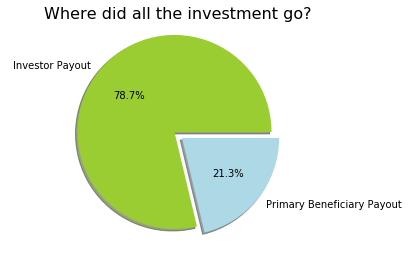

In [11]:
total_investment = df['Investment'].sum()
print(f"Total MATIC investment by investor: {df['Investment'].sum()}, ({df['Investment'].sum()/total_investment*100 :0.2f}%)")
print(f"Total MATIC withdrawn and referral bonus paid to investor: {df['withdraw'].sum()}, ({df['withdraw'].sum()/total_investment*100 :0.2f}%)")
print(f"Total MATIC paid out to primary beneficiary: {df['reward'].sum()}, ({df['reward'].sum()/total_investment*100 :0.2f}%)")
labels = ['Investor Payout', 'Primary Beneficiary Payout']
payout = [df['withdraw'].sum(), df['reward'].sum()]
plt.pie(payout, labels=labels, autopct='%1.1f%%', colors=['yellowgreen', 'lightblue'], 
        startangle=0, explode=(0.1, 0), shadow=True)
plt.axis('equal')
plt.title('Where did all the investment go?', fontsize=16)

Text(0.5,0.98,'Daily Investment and Withdraw Distribution')

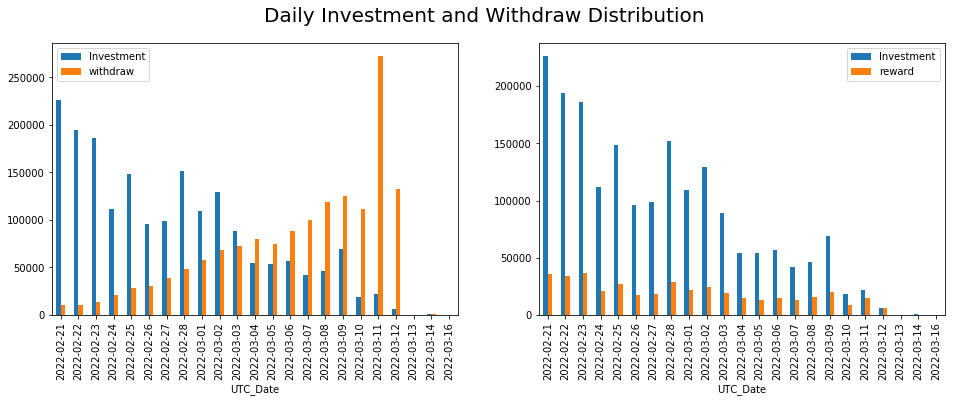

In [12]:
fig, ax = plt.subplots(1,2)
df[['Investment', 'withdraw']].plot.bar(ax=ax[0])
df[['Investment', 'reward']].plot.bar(ax=ax[1])
fig.set_figheight(5)
fig.set_figwidth(16)
fig.suptitle('Daily Investment and Withdraw Distribution', fontsize=20)

Text(0.5,0.98,'Daily contract balance and daily change')

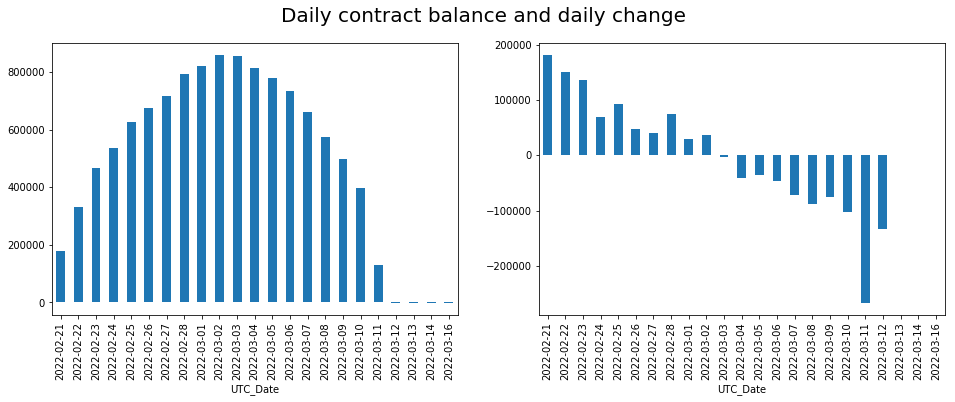

In [13]:
fig, ax = plt.subplots(1,2)
df['balance'].plot.bar(ax=ax[0])
df['daily gain or drain'].plot.bar(ax=ax[1])
fig.set_figheight(5)
fig.set_figwidth(16)
fig.suptitle('Daily contract balance and daily change', fontsize=20)

#### would hourly chart give us additional insight?

In [14]:
base = all_invest['UTC_Date'].min()
all_invest['hour_passed'] = all_invest['UTC_Date'].apply(lambda x: math.floor((x - base).total_seconds() / 3600))
user_withdraw['hour_passed'] = user_withdraw['UTC_Date'].apply(lambda x: math.floor((x - base).total_seconds() / 3600))
primary_beneficiary['hour_passed'] = primary_beneficiary['UTC_Date'].apply(lambda x: math.floor((x - base).total_seconds() / 3600))
df2h = all_invest.groupby(all_invest['hour_passed']).sum()
df3h = user_withdraw.groupby(user_withdraw['hour_passed']).sum()
df4h = primary_beneficiary.groupby(primary_beneficiary['hour_passed']).sum()
dfh = pd.concat([df2h, df3h, df4h], axis=1)
dfh['hourly gain or drain'] = dfh['Investment'] - dfh['withdraw'] - dfh['reward']
dfh['balance'] = df['daily gain or drain'].cumsum()
print("Total MATIC investment: ", dfh['Investment'].sum())
print("Total MATIC withdrew & reward: ", dfh['withdraw'].sum())
print("Total MATIC reward to primary beneficiary: ", dfh['reward'].sum())
print("Total blance: ", dfh['hourly gain or drain'].sum())

C:\Users\davefang\.conda\envs\textmining\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\davefang\.conda\envs\textmining\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Total MATIC investment:  1909919.6340416346
Total MATIC withdrew & reward:  1503649.1605043055
Total MATIC reward to primary beneficiary:  406478.3796075611
Total blance:  26147.910136007355


C:\Users\davefang\.conda\envs\textmining\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


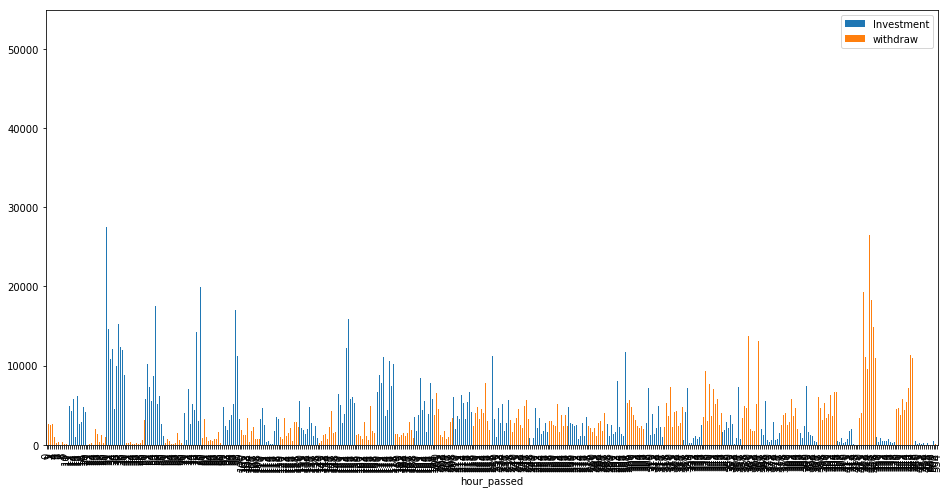

In [15]:
dfh[['Investment', 'withdraw']].plot.bar(figsize=(16,8))

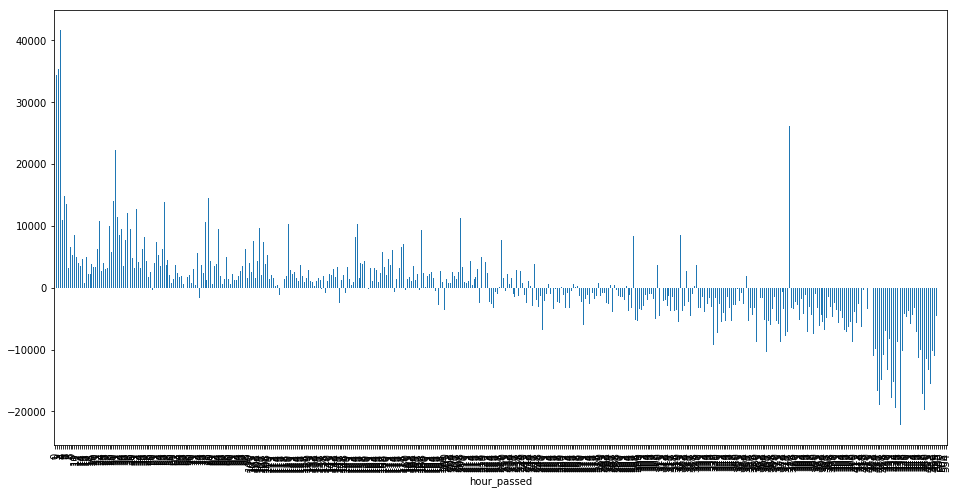

In [16]:
dfh["hourly gain or drain"].plot.bar(figsize=(16,8))

#### Let's also examine which investor has made money and which investor are still trying to make the first deposit back

Out of total 5568 players, 4284 players, or 76.94%, are still under water
1136 players has not gotten anything back yet
1284 players break even at least


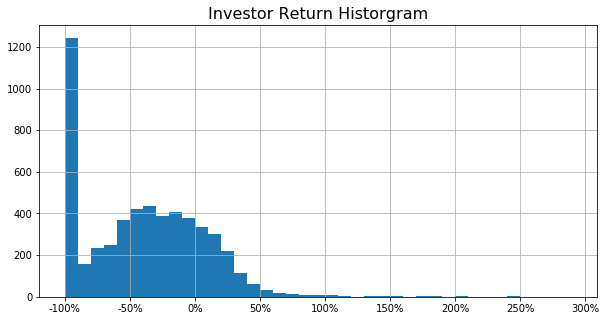

In [17]:
user_deposit_by_user = all_invest.groupby(all_invest['from'])['Investment'].sum()
user_withdraw_by_user = user_withdraw.groupby(user_withdraw['to'])['withdraw'].sum()

user = pd.concat([user_deposit_by_user, user_withdraw_by_user], axis=1)
user['withdraw'] = user['withdraw'].fillna(0)
user.dropna(inplace=True)

user['return'] = (user.withdraw / user.Investment - 1.0) * 100
negative_returns = np.sum(user['return']<0)
print(f"Out of total {user.shape[0]} players, {negative_returns} players, or{negative_returns/user.shape[0] * 100 : .2f}%, are still under water")
print(f"{np.sum(user['return'] == -100)} players has not gotten anything back yet")
print(f"{np.sum(user['return'] >= 0)} players break even at least")
hist = user['return'].hist(bins=[x for x in range(-100, 300, 10)], figsize=(10,5))
hist.set_title('Investor Return Historgram', fontsize=16)
hist.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

In [18]:
# let's figure out when did investor first invest
user_earliest_investment_date = all_invest.groupby(all_invest['from'])['UTC_Date'].min()
user = pd.concat([user, user_earliest_investment_date], axis=1)

ug = user.groupby(user['UTC_Date'].dt.date).count()
ugn = user[user['return']<0].groupby(user['UTC_Date'].dt.date).count()
df6 = pd.concat([ug['return'], ugn['return']], axis=1)
df6.columns.values[0] = 'Total Investor'
df6.columns.values[1] = 'Total Negative Returns'
df6['% positive return'] = 100 - df6['Total Negative Returns'] / df6['Total Investor'] * 100
df6['% negative return'] = df6['Total Negative Returns'] / df6['Total Investor'] * 100

Text(0.5,0.98,'Investor Distribution based on first investment day')

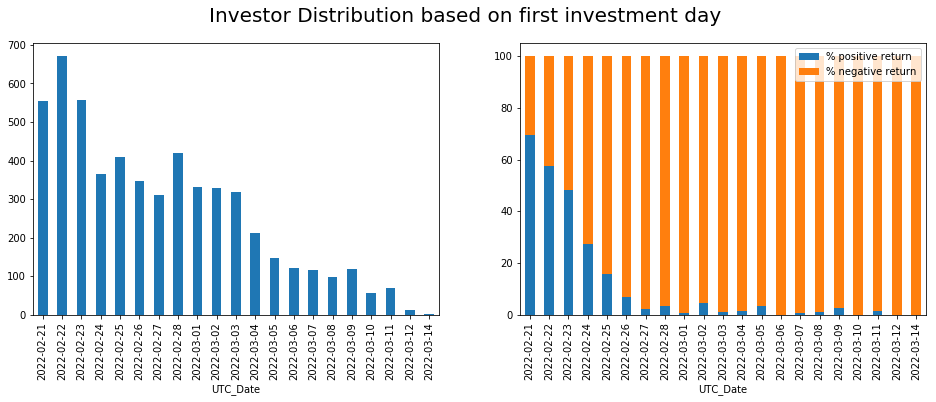

In [19]:
fig, ax = plt.subplots(1,2)
df6['Total Investor'].plot.bar(ax=ax[0])
df6[['% positive return', '% negative return']].plot.bar(stacked=True, ax=ax[1])
fig.set_figheight(5)
fig.set_figwidth(16)
fig.suptitle('Investor Distribution based on first investment day', fontsize=20)

It is a bit surprising that there are some investors who invested on day 1 and day 2 still lose money as the contract lasted 20 days. This suggests these investors are less informed about the nature of the contract or they could not monitor the contract balance closely to make the correct decision. Also there are some investors invested on 3/14/2022 which is one day after the contract balance reached 0.

#### Sorting investors by investment and date

In [20]:
sorted_user = user.sort_values(by='Investment', ascending=False)
pd.set_option('display.max_rows', None)
sorted_user.head(100)

,Investment,withdraw,return,UTC_Date
0x3eb9a2c4e7daa36a79c7114ba966822436dac5e1,35900.00,5983.470602,-83.332951,2022-03-09 04:58:54
0xb8107f841d81c8c54c8d374401c3ae2e287836f6,25240.00,27778.224358,10.056356,2022-02-22 16:06:47
0x1ad14d33a49c0916e1319a7289c6a0985cfa6422,22400.00,29488.930232,31.647010,2022-02-21 13:24:24
0x2716953ccda077acd1180a6f6784a97e471ed84f,20000.00,26266.817787,31.334089,2022-02-21 15:27:25
0x813edf3f8e492bd7f1550c38c75e4636c84241f3,19660.00,13917.130861,-29.210932,2022-02-22 09:33:41
0xfcf0e1ccd5973b352a7512c634cb60cfba53416c,17500.00,20534.821752,17.341839,2022-02-21 18:03:39
0x25a4e4df8e2df32ec28d2ebe17abaffcfda8eb78,16015.00,20852.826465,30.208095,2022-02-21 13:31:38
0x6e5de945f867a55cb6e444708213210c9159729b,14805.75,0.000000,-100.000000,2022-03-07 20:17:26
0x8632004ae89f5001123d71127feafe96a4dec6b3,13800.00,20067.216489,45.414612,2022-02-21 14:43:42
0x5198b5905e7547d3cba18be1241fa32caf353bf1,13725.00,13472.292464,-1.841221,2022-02-21 16:24:06


In [21]:
user['date_only'] = user['UTC_Date'].dt.date
sorted_user_date_then_investment = user.sort_values(by=['date_only','Investment'], ascending=[True, False])
sorted_user_date_then_investment.head(100)

,Investment,withdraw,return,UTC_Date,date_only
0x1ad14d33a49c0916e1319a7289c6a0985cfa6422,22400.0000,29488.930232,31.647010,2022-02-21 13:24:24,2022-02-21
0x2716953ccda077acd1180a6f6784a97e471ed84f,20000.0000,26266.817787,31.334089,2022-02-21 15:27:25,2022-02-21
0xfcf0e1ccd5973b352a7512c634cb60cfba53416c,17500.0000,20534.821752,17.341839,2022-02-21 18:03:39,2022-02-21
0x25a4e4df8e2df32ec28d2ebe17abaffcfda8eb78,16015.0000,20852.826465,30.208095,2022-02-21 13:31:38,2022-02-21
0x8632004ae89f5001123d71127feafe96a4dec6b3,13800.0000,20067.216489,45.414612,2022-02-21 14:43:42,2022-02-21
0x5198b5905e7547d3cba18be1241fa32caf353bf1,13725.0000,13472.292464,-1.841221,2022-02-21 16:24:06,2022-02-21
0xbc5819e49ac9807ffe8b04c48a432eff436b6f15,9883.0000,11129.431734,12.611876,2022-02-21 17:03:25,2022-02-21
0x1d4ce660e3bdbaaee5dd05098a1295cbd2174696,8710.0000,11212.583747,28.732305,2022-02-21 17:24:14,2022-02-21
0x1e00677d4344d1ff8819f1f0b570d560f1f76f9f,6606.0000,7316.416712,10.754113,2022-02-21 13:27:08,2022-02-21
0xcb53bb0a7086363b7b962a2a5a877fcdcc76555a,6000.0000,7595.350999,26.589183,2022-02-21 13:15:29,2022-02-21
